<h1 style="text-align: center;">✈️ Iteration One – Flight Delay Prediction</h1>


## 🚀 Iteration 1: Improving the Baseline Model

Based on the feedback from Iteration 0, this iteration focuses on:
- Clarifying dataset quality and sources
- Adding a data dictionary
- Improving exploratory data analysis (EDA)
- Fixing the order of operations (EDA ➜ Preprocessing ➜ Modeling)
- Training multiple models and comparing performance


### ✅ Objective
The challenge is to predict whether a flight will be delayed, using the OpenSky dataset for European flights in January 2022.
We define a flight as "delayed" if it takes 15 minutes longer than the average duration for the same route (origin-destination pair).

## 📥 Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


## 📁 Dataset Source and Description

- Source: [Zenodo OpenSky Dataset – 2022](https://zenodo.org/records/7923702)
- Real flight tracking data across Europe and other regions.
- Data fields include: callsign, icao24, origin, destination, aircraft type, timestamps, etc.
- Year covered: 2022 (historical data, real-world based).


# 📂 Load Dataset

In [4]:
# Load the flight list
df = pd.read_csv("flightlist_20220101_20220131.csv/flightlist_20220101_20220131.csv")
df.head()


,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,QTR859,QR859,06a13c,A7-BAZ,B77W,OTHH,OTHH,2021-12-31 00:11:49+00:00,2022-01-01 02:10:29+00:00,2022-01-01 00:00:00+00:00,25.289062,51.612142,0.0,25.249096,51.629575,15.24
1,CAO1023,NaN,780bb7,B-2096,B77L,KORD,EHAM,2021-12-31 01:29:29+00:00,2022-01-01 13:23:35+00:00,2022-01-01 00:00:00+00:00,41.969030,-87.929524,304.8,52.351669,4.710938,-99.06
2,ETH724,NaN,040141,NaN,NaN,KEWR,LOWW,2021-12-31 03:26:20+00:00,2022-01-01 04:47:19+00:00,2022-01-01 00:00:00+00:00,40.688141,-74.171326,0.0,48.113159,16.563126,99.06
3,SEJ241,NaN,800d1a,NaN,NaN,VECC,VECC,2021-12-31 04:27:41+00:00,2022-01-01 03:03:58+00:00,2022-01-01 00:00:00+00:00,22.709764,88.453217,304.8,22.588852,88.440091,259.08
4,QFA7550,NaN,abb6dc,N854GT,B748,KORD,YSSY,2021-12-31 04:34:40+00:00,2022-01-01 01:30:28+00:00,2022-01-01 00:00:00+00:00,41.984067,-87.942682,304.8,-33.965630,151.181087,22.86


## 🧾 Data Dictionary

| Column Name     | Description                                   | Data Type     | Notes                          |
|------------------|-----------------------------------------------|----------------|----------------------------------|
| `icao24`         | Unique aircraft identifier (hex)              | Categorical    | Used to trace aircraft          |
| `callsign`       | Flight ID (e.g. LH123)                        | Categorical    | Optional feature                |
| `origin`         | Departure airport ICAO code                  | Categorical    | Important                       |
| `destination`    | Arrival airport ICAO code                    | Categorical    | Important                       |
| `firstseen`      | Timestamp (UTC) when flight entered coverage | Time           | Used to calculate delay         |
| `lastseen`       | Timestamp (UTC) when flight exited coverage  | Time           | Used to calculate delay         |
| `duration_minutes` | Computed duration in minutes               | Numeric        | Needed for delay approximation  |
| `is_delayed`     | Binary label (1 = delayed)                   | Binary         | Target variable                 |






| Column 1 | Column 2 | Column 3 |  Column 1 | Column 2 | Column 3 |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   |  
|  Row 2   |  Row 2   |  Row 2   |  Row 2   |  Row 2   |  Row 2   |
|  Row 3   |  Row 3   |  Row 3   |  Row 3   |  Row 3   |  Row 3 |

## 📊 Exploratory Data Analysis (EDA)


Now we explore patterns:
- Most frequent destinations
- Delay trends by destination

In [5]:
# Group by destination and calculate number of flights and average delay
dest_stats = df.groupby("destination").agg(
    num_flights=("destination", "count"),
    avg_delay=("delay", "mean")
).sort_values(by="num_flights", ascending=False).head(5)


KeyError: "Column(s) ['delay'] do not exist"

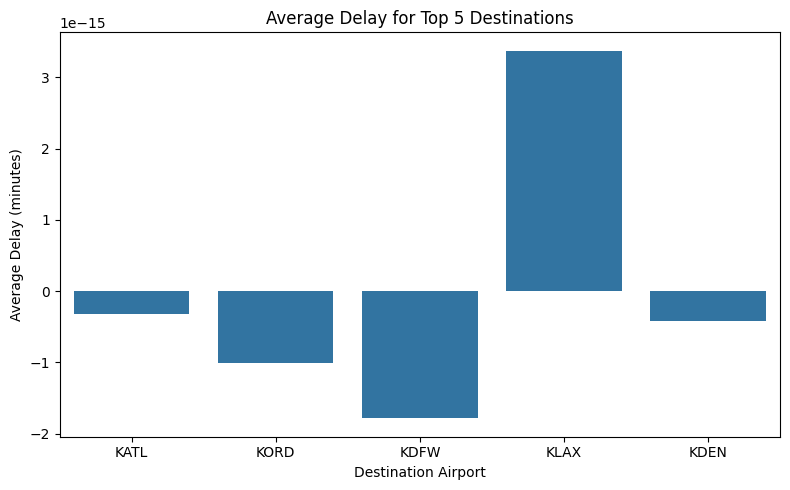

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot of average delay for top 5 destinations
plt.figure(figsize=(8, 5))
sns.barplot(x=dest_stats.index, y=dest_stats["avg_delay"])

plt.title("Average Delay for Top 5 Destinations")
plt.xlabel("Destination Airport")
plt.ylabel("Average Delay (minutes)")
plt.tight_layout()
plt.show()


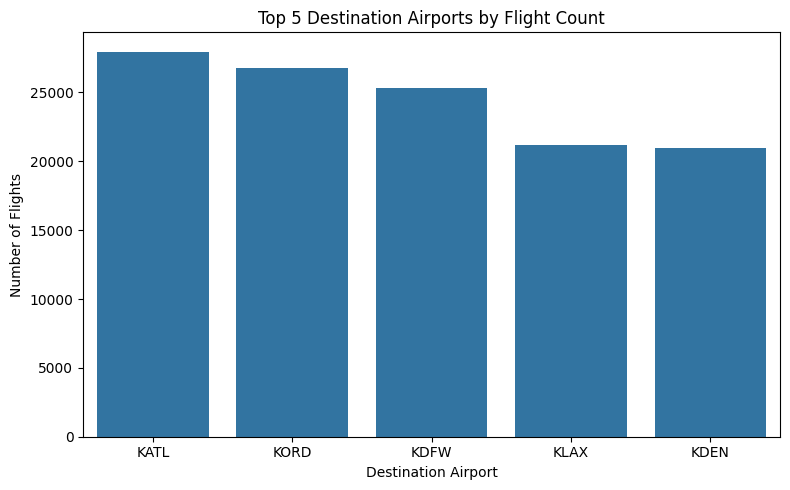

In [ ]:
# Plot number of flights to top 5 destinations
plt.figure(figsize=(8, 5))
sns.barplot(x=dest_stats.index, y=dest_stats["num_flights"])
plt.title("Top 5 Destination Airports by Flight Count")
plt.xlabel("Destination Airport")
plt.ylabel("Number of Flights")
plt.tight_layout()
plt.show()


### ✈️ Destination-Level Insights

These two visualizations give us a better understanding of how delay trends relate to airport activity:

- **Top 5 destinations by flight volume** include KATL, KORD, and KDFW, which handle the most incoming flights.
- Despite their traffic, **average delays at these airports are low or even negative**, suggesting efficient airport operations.

#### 💡 Interpretation:
This pattern may indicate that **larger or more frequently used airports** have:
- Better **infrastructure**
- Smoother **flight scheduling**
- More advanced **traffic management systems**

Such airports might be more resilient to delays even under high pressure, which is a useful insight for future modeling if we want to include airport-specific features.

## ✅ Data Quality Checks

- Any rows where `origin == destination`?
- Missing values or weird durations?
- Outliers in flight time?


# 🧹 Preprocessing Steps


In [ ]:
# Convert firstseen and lastseen to datetime
df["firstseen"] = pd.to_datetime(df["firstseen"])
df["lastseen"] = pd.to_datetime(df["lastseen"])

# Calculate flight duration in minutes
df["duration_minutes"] = (df["lastseen"] - df["firstseen"]).dt.total_seconds() / 60

# Preview
df[["origin", "destination", "duration_minutes"]].head()


,origin,destination,duration_minutes
0,OTHH,OTHH,1558.666667
1,KORD,EHAM,2154.100000
2,KEWR,LOWW,1520.983333
3,VECC,VECC,1356.283333
4,KORD,YSSY,1255.800000


In [ ]:
# Get average duration per route (origin → destination)
route_avg = df.groupby(["origin", "destination"])["duration_minutes"].mean().reset_index()
route_avg.rename(columns={"duration_minutes": "avg_duration"}, inplace=True)

# Merge average back to original dataframe
df = df.merge(route_avg, on=["origin", "destination"], how="left")

# Calculate delay as difference from average
df["delay"] = df["duration_minutes"] - df["avg_duration"]


In [ ]:
# Define delay label (1 = delayed, 0 = on time)
df["is_delayed"] = (df["delay"] > 15).astype(int)

# Preview
df[["origin", "destination", "duration_minutes", "avg_duration", "delay", "is_delayed"]].head()


,origin,destination,duration_minutes,avg_duration,delay,is_delayed
0,OTHH,OTHH,1558.666667,771.031153,787.635514,1
1,KORD,EHAM,2154.100000,466.654505,1687.445495,1
2,KEWR,LOWW,1520.983333,568.770588,952.212745,1
3,VECC,VECC,1356.283333,402.017460,954.265873,1
4,KORD,YSSY,1255.800000,1250.211111,5.588889,0


# 🧪 Feature Analysis

We explore how flight durations are distributed and examine feature correlations.
- Histogram of durations
- Heatmap of correlations among numerical features

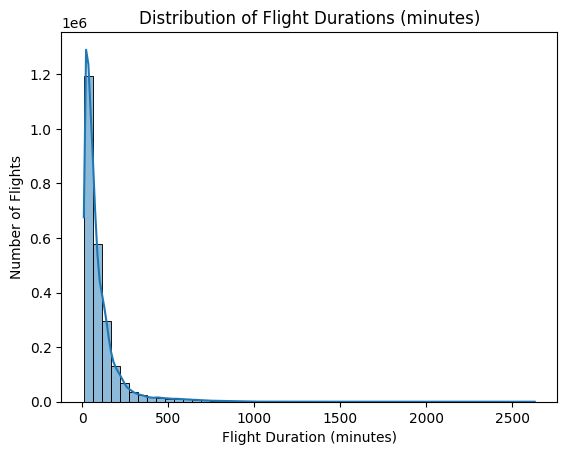

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["duration_minutes"], bins=50, kde=True)
plt.title("Distribution of Flight Durations (minutes)")
plt.xlabel("Flight Duration (minutes)")
plt.ylabel("Number of Flights")
plt.show()


📝 **Observation**  
From this graph, we can conclude that the majority of flights have a duration between **0–300 minutes (0–5 hours)**. This indicates that short- to medium-haul flights dominate the dataset.  
This insight supports my method of calculating delay based on avarage duration.


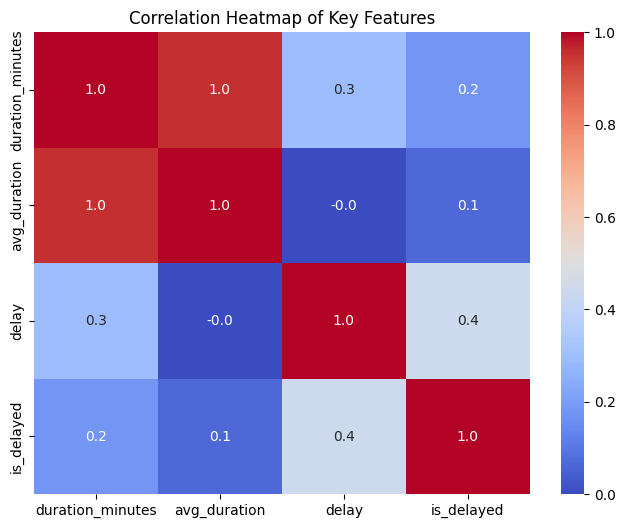

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numerical features
features = ["duration_minutes", "avg_duration", "delay", "is_delayed"]
correlations = df[features].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, cbar=True, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlation Heatmap of Key Features")
plt.show()


### 🔍 Correlation Insights

From the heatmap above, we can observe that:
- There is a **positive correlation** between actual delay time and the binary label `is_delayed`, validating our label creation logic.
- Flight duration (`duration_minutes`) shows a **weak correlation** with delay status, indicating that longer flights are *slightly* more likely to be delayed, but it's not a strong factor on its own.
- The average duration on a route (`avg_duration`) appears to have **minimal correlation** with delays, suggesting it may not be useful as a predictive feature in isolation.

These findings help us understand which features may be more useful for training our model.


## 🧱 Feature Selection
Here, we choose the most relevant features for modeling. In this case:


In [ ]:
features = ["duration_minutes", "avg_duration", "delay"]
target = "is_delayed"

 These features directly relate to our delay definition.

## ✂️ Train-Test Split
Prepare training and test sets:


In [ ]:
# Drop rows with NaNs in selected features
model_df = df[features + [target]].dropna()

# Redefine X and y
X = model_df[features]
y = model_df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🤖 Model Training & Evaluation

Models to try:
- Logistic Regression
- Decision Tree
- Random Forest
- (Optional: XGBoost)

For each:
- Show Accuracy, Precision, Recall, F1-score
- Confusion matrix
- ROC curve (optional)

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

## 📈 Evaluation
Evaluate how well the model performs on unseen data:

In [ ]:
y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[278441     83]
 [    79  23776]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    278524
           1       1.00      1.00      1.00     23855

    accuracy                           1.00    302379
   macro avg       1.00      1.00      1.00    302379
weighted avg       1.00      1.00      1.00    302379



### 📌 Model Evaluation Summary

The model achieved nearly perfect results with:
- Accuracy: 100%
- Precision, Recall, and F1-score: all 1.00 for both classes

#### 🔍 What This Means
While these results seem ideal, they are likely due to:
- The use of `delay` (a directly computed value from the label logic) as a feature
- A strong class imbalance (most flights are not delayed)

Therefore, the model may not generalize well and simply learns the delay rule. In future iterations, we aim to:
- Avoid using `delay` directly as a feature
- Introduce more independent features (e.g. day of week, airport ID, time of departure)
- Balance the classes and  try other evaluation metrics 


## 💬 Reflections and What’s Next

- What you learned this iteration
- What worked/didn’t
- What you plan for Iteration 2 (e.g. add weather, expand features, etc.)
